In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("sample_data/Soja_v1.csv", sep = ";")
df = df.sort_values(by='Data').reset_index(drop=True)
# df.set_index("Data", inplace = True)
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0
1,2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0
2,2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0
3,2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0
4,2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0


In [ ]:
!pip install python-bcb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00


In [ ]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2004-03-01',
                  end='2024-09-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

In [ ]:
df["USD"] = df_usd["USD"]
df.set_index("Data", inplace = True)
df.head()

,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD
Data,,,,,,,,,
2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0,2.905457
2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0,2.905985
2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0,3.100419
2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0,3.129148
2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0,3.036777


In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams

rcParams['figure.figsize']=15,6

from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, signif=0.05, name='', verbose=False):


    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

def plot_predictions(testing_dates, y_test, prediction):
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
    _, ax = plt.subplots(figsize=(10, 5))
    df_test.plot(ax=ax, label="Actual", x="date", y="actual")
    df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
    plt.legend(["Actual", "Prediction"])
    plt.show()

In [ ]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

check_stationarity(train["Estadual"], name=train["Estadual"].name)

    Augmented Dickey-Fuller Test on "Estadual" 
    -----------------------------------------------
ADF Statistic: 0.025614
p-value: 0.960600
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575
Non-stationary


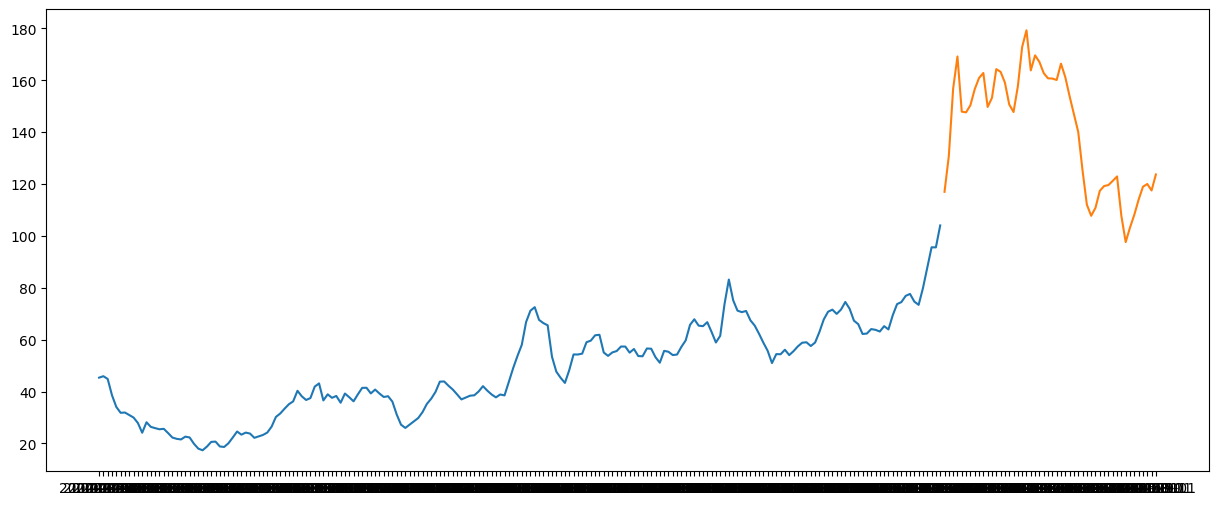

In [ ]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

# train = train.Estadual
# test = test.Estadual

plt.plot(train.Estadual)
plt.plot(test.Estadual)

In [ ]:
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df["Estadual"])

##Dado Não-Estacionário > I = 0

(0.22413105593652022, True)

In [ ]:
train.head()

,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD
Data,,,,,,,,,
2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0,2.905457
2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0,2.905985
2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0,3.100419
2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0,3.129148
2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0,3.036777


In [ ]:
arima_model = auto_arima(train.Estadual, X = train[["USD", "País", "Último", "Máxima"]],start_p=0, d=0, start_q=0,
                         max_p = 5, max_d = 5, max_q = 5,
                         start_P = 0, D = 0, start_Q=5,
                         max_P=5, max_D=5, max_Q=5,
                         m=12, seasonal=True, error_action ="warn",
                         Trace=True, random_state=20, n_fits=50)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [ ]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  196
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -320.816
Date:                            Tue, 29 Oct 2024   AIC                            657.633
Time:                                    23:34:53   BIC                            683.858
Sample:                                         0   HQIC                           668.250
                                            - 196                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
USD           -0.5620      0.549     -1.024      0.306      -1.638       0.514
País           0.9777      0.026     37.464      0.000       0.927       1.029
Último     -2.996e-06   3.48e-06     -0.862      0.389   -9.81e-06    3.82e-06
Máxima     -8.945e-06   3.69e-06     -2.422      0.015   -1.62e-05   -1.71e-06
ar.L1          0.8410      0.046     18.169      0.000       0.750       0.932
ar.S.L12       0.2149      0.079      2.716      0.007       0.060       0.370
ar.S.L24       0.3384      0.083      4.092      0.000       0.176       0.500
sigma2         1.7013      0.180      9.455      0.000       1.349       2.054
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                14.40
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
prediction = pd.DataFrame(arima_model.predict(n_periods=len(test), X=test[["USD", "País", "Último", "Máxima"]]),
                          # index=test.index
                          )
prediction.columns = ["predicted_Estadual"]
prediction.index = test.index

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<ipython-input-108-a0754def28b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Data"] = test.index


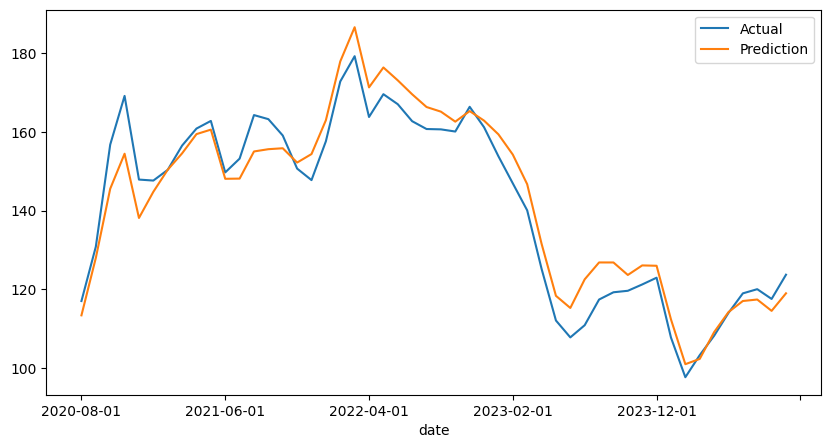

In [ ]:
test["Data"] = test.index
testing_dates = test.Data

plot_predictions(testing_dates, test.Estadual, prediction.predicted_Estadual)

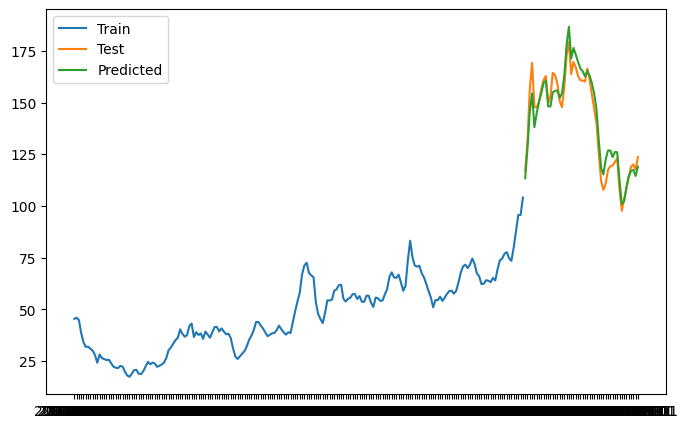

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train.Estadual, label = "Train")
plt.plot(test.Estadual, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.legend(loc='upper left')
plt.show()

In [ ]:
test = pd.DataFrame(test)
test["predict_Estadual"] = prediction['predicted_Estadual']
test

,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,predict_Estadual
Data,,,,,,,,,,
2020-08-01,Soja,117.0222,113.3375,0,95250.00000,89175.00000,96688.00000,86538.00000,5.280191,113.382452
2020-09-01,Soja,130.8449,128.3004,0,1.02175,95062.00000,1.04650,94288.00000,5.461233,127.992740
2020-10-01,Soja,156.7972,147.4121,0,1.05688,1.02338,1.09388,1.01300,5.399486,145.577075
2020-11-01,Soja,169.1946,157.3982,0,1.16875,1.06025,1.19962,1.04162,5.625790,154.487921
2020-12-01,Soja,147.9145,140.9301,0,1.31025,1.16962,1.32060,1.14262,5.417835,138.151092
2021-01-01,Soja,147.6618,148.7721,0,1.36438,1.31025,1.43625,1.29825,5.145586,144.804565
2021-02-01,Soja,150.3854,154.5318,0,1.40788,1.37650,1.44575,1.33812,5.356245,150.414331
2021-03-01,Soja,156.5591,158.7933,0,1.43675,1.41525,1.45988,1.36425,5.416494,154.586201
2021-04-01,Soja,160.8866,163.2929,0,1.53562,1.44725,1.57475,1.37850,5.646148,159.479233


In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

In [ ]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

In [ ]:
evaluate_model(test["Estadual"], test["predict_Estadual"])

MAE: 4.974233537720149
RMSE: 5.894276326023278
MAPE: 0.03549397844439522
R-Squared: 0.9323581186630377


Não-estacionário para Estacionário


In [ ]:
teste = pd.Series(df["Estadual"], name="Estadual")
teste.describe()

,Estadual
count,246.000000
mean,67.186526
std,42.222066
min,17.383800
25%,37.853025
50%,55.675250
75%,74.322025
max,179.294900


In [ ]:
df = pd.read_csv("sample_data/Soja_v1.csv", sep = ";")
df = df.sort_values(by='Data').reset_index(drop=True)
# df.set_index("Data", inplace = True)
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0
1,2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0
2,2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0
3,2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0
4,2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0


In [ ]:
df['Data'] = pd.to_datetime(df['Data'])
df["USD"] = df_usd["USD"]
df = df.set_index('Data')
monthly_summary = df.Estadual.resample('ME').mean().ffill()

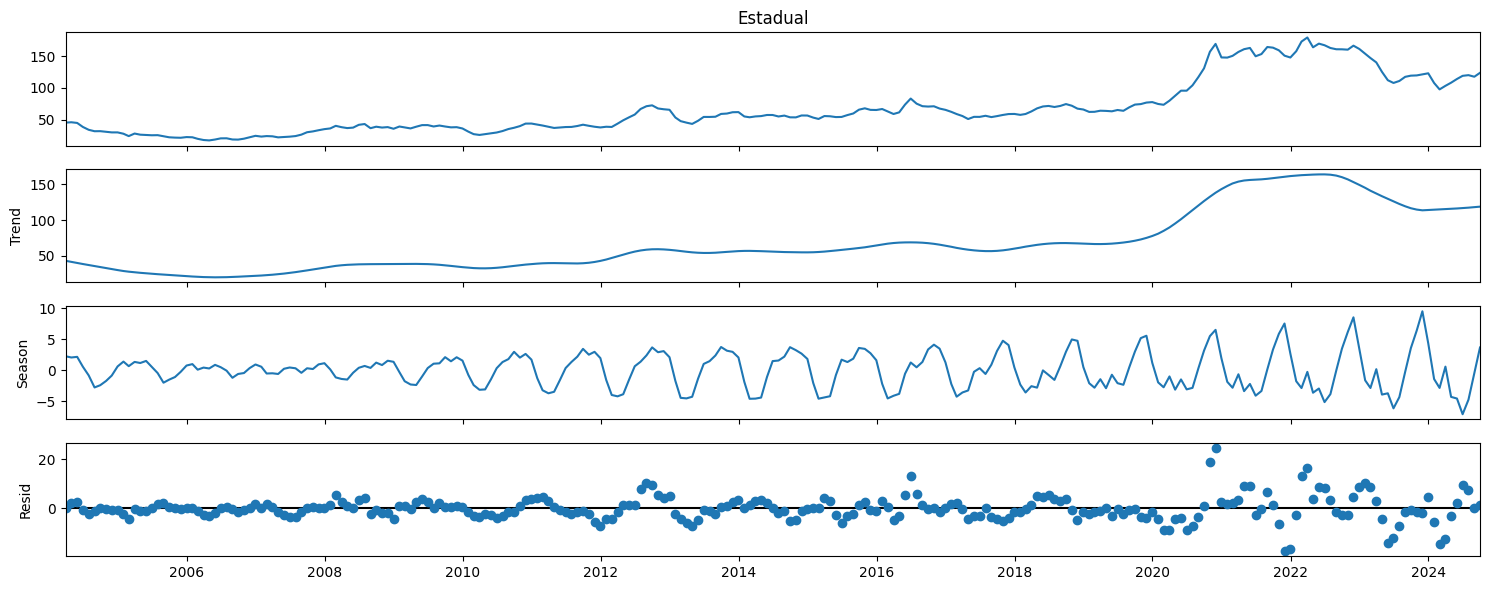

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(monthly_summary, seasonal=13)
res = stl.fit()
fig = res.plot()

In [ ]:
#Aplicanto a função Log para converter os dados para estacionários

df_log=np.sqrt(df['Estadual'])
df_diff=df_log.diff().dropna()

In [ ]:
# from pmdarima.arima import ADFTest

# adf_test = ADFTest(alpha = 0.05)
# adf_test.should_diff(df_diff)

##Dado Estacionário > I = 1

check_stationarity(df_diff, name=df_diff.name)

    Augmented Dickey-Fuller Test on "Estadual" 
    -----------------------------------------------
ADF Statistic: -10.111737
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Stationary


In [ ]:
df["Estadual"] = df_diff
df = df.bfill()
df.head()

,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD
Data,,,,,,,,,
2004-03-01,Soja,0.042021,50.0455,0,1.034,1.000,1.064,92600.0,2.905457
2004-04-01,Soja,0.042021,48.7279,0,81400.000,1.036,1.063,81200.0,2.905985
2004-05-01,Soja,-0.079639,47.4930,0,89300.000,82800.000,94000.000,0.0,3.100419
2004-06-01,Soja,-0.486489,40.7781,0,59950.000,89200.000,1.035,59900.0,3.129148
2004-07-01,Soja,-0.374228,37.5474,0,62725.000,59100.000,71200.000,56500.0,3.036777


In [ ]:
train_size = int(len(df.Estadual.dropna()) * 0.75)

train, test = df[0:train_size], df[train_size:len(df)]
# train, test = df.Estadual.dropna()[0:size], df.Estadual.dropna()[size:len(df.Estadual.dropna())]
# test = test.reset_index()['Estadual']
history = [x for x in train.Estadual]
predictions = []

In [ ]:
arima_model = auto_arima(train.Estadual, X = train[["USD", "País"]], start_p=0, d=1, start_q=0,
                         max_p = 5, max_d = 5, max_q = 5,
                         start_P = 0, D = 1, start_Q=5,
                         max_P=5, max_D=5, max_Q=5,
                         m=13, seasonal=True, error_action ="warn",
                         Trace=True, random_state=20, n_fits=50)

In [ ]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  184
Model:             SARIMAX(1, 1, 1)x(5, 1, 1, 13)   Log Likelihood                  13.299
Date:                            Wed, 30 Oct 2024   AIC                             -4.598
Time:                                    00:08:19   BIC                             29.896
Sample:                                         0   HQIC                             9.399
                                            - 184                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
USD           -0.1047      0.065     -1.603      0.109      -0.233       0.023
País           0.0063      0.004      1.589      0.112      -0.001       0.014
ar.L1          0.4219      0.108      3.924      0.000       0.211       0.633
ma.L1         -0.9481      0.053    -17.827      0.000      -1.052      -0.844
ar.S.L13      -0.2865      0.242     -1.184      0.237      -0.761       0.188
ar.S.L26      -0.2669      0.195     -1.371      0.170      -0.648       0.115
ar.S.L39      -0.2279      0.182     -1.252      0.211      -0.585       0.129
ar.S.L52      -0.3005      0.156     -1.932      0.053      -0.605       0.004
ar.S.L65      -0.2485      0.144     -1.723      0.085      -0.531       0.034
ma.S.L13      -0.6950      0.263     -2.643      0.008      -1.210      -0.180
sigma2         0.0413      0.004     10.286      0.000       0.033       0.049
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):                32.67
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.54
Prob(H) (two-sided):                  0.85   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
prediction = pd.DataFrame(arima_model.predict(n_periods=len(test), X = test[["USD", "País"]]),
                          # index=test.index
                          )
prediction.columns = ["predicted_Estadual"]
prediction.index = test.index
prediction

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_Estadual
Data,
2019-08-01,-0.011882
2019-09-01,-0.056101
2019-10-01,-0.084652
2019-11-01,0.102759
2019-12-01,0.095207
...,...
2024-05-01,0.227837
2024-06-01,0.127428
2024-07-01,0.082220


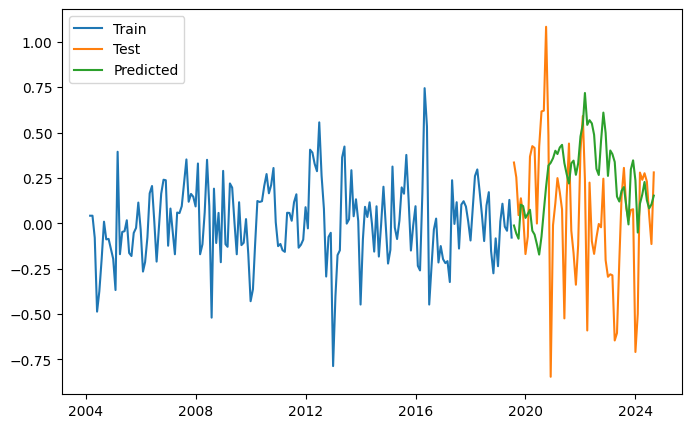

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train.Estadual, label = "Train")
plt.plot(test.Estadual, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.legend(loc='upper left')
plt.show()

In [ ]:
test = pd.DataFrame(test)
test["predict_Estadual"] = prediction['predicted_Estadual']
test

,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,predict_Estadual
Data,,,,,,,,,,
2019-08-01,Soja,0.335122,71.6310,0,86825.00000,88075.00000,89662.00000,85262.00000,3.779339,-0.011882
2019-09-01,Soja,0.253732,75.7721,0,90425.00000,86638.00000,90662.00000,85112.00000,4.019982,-0.056101
2019-10-01,Soja,0.045107,76.9515,0,93175.00000,90412.00000,94538.00000,90338.00000,4.121500,-0.084652
2019-11-01,Soja,0.137983,78.0108,0,87662.00000,93100.00000,94212.00000,87612.00000,4.086987,0.102759
2019-12-01,Soja,0.042304,78.6838,0,94350.00000,87662.00000,94350.00000,86762.00000,4.155345,0.095207
...,...,...,...,...,...,...,...,...,...,...
2024-05-01,Soja,0.276085,118.2335,0,1.20350,1.16100,1.25650,1.15625,5.129095,0.227837
2024-06-01,Soja,0.230279,121.3981,0,1.15050,1.20425,1.20550,1.14625,5.133048,0.127428
2024-07-01,Soja,0.048675,121.7345,0,1.02850,1.14825,1.19150,1.02050,5.388975,0.082220


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

In [ ]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

In [ ]:
evaluate_model(test["Estadual"], test["predict_Estadual"])

MAE: 0.379506009372794
RMSE: 0.47703711657063835
MAPE: 5.539886294360534
R-Squared: -0.8047131284284901
